# Random Forest Model

So far decision trees are the most accurate models in predicting the classes. Random Forest and Gradient Boosted trees perform somewhat similarly.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
import matplotlib.colors as colors
import matplotlib.cm as cmx
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import sklearn
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC 
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

from Notebook_helpers import load_data
from Notebook_helpers.modeling_helpers import *

%matplotlib inline

## Read in Data

In [19]:
df, train, val, test = load_data.load_coral_data(complete=True, CV=False, convert_to_categorical=True)
print(train.shape)
print(val.shape)

(396, 46)
(100, 46)


In [12]:
# isolate the predictors and labels for both the training and test set
train_X = train.iloc[:, 14:34]
train_y = train['Regime']

val_X = val.iloc[:, 14:34]
val_y = val['Regime']

pred_names = df.iloc[:, 14:34].columns
pred_names

Index(['Effluent', 'Sedimentation', 'New_Development', 'Habitat_Modification',
       'Invasive_Algae', 'Fishing_Comm_Total', 'Fishing_NonComm_Boat_Total',
       'Fishing_NonComm_Shore_Line', 'Fishing_NonComm_Shore_Net',
       'Fishing_NonComm_Shore_Spear', 'SST_CLIM_M', 'SST_STD', 'CHL_CLIM_M',
       'CHL_ANOM_F', 'PAR_CLIM_M', 'PAR_STD', 'WAV_CLIM_M', 'WAV_ANOM_F',
       'Complexity', 'Depth'],
      dtype='object')

## Run Model

In [10]:
rf_model = sklearn.ensemble.RandomForestClassifier(n_estimators=10, max_depth=2, random_state=229)
rf_model.fit(train_X, train_y)

estimates = rf_model.predict(val_X)

#### evaluate performance

Misclassified samples: 34
Classification Report:
              precision    recall  f1-score   support

           1       0.80      0.92      0.86        26
           2       0.64      0.89      0.75        28
           3       0.64      0.36      0.46        25
           5       0.47      0.38      0.42        21

   micro avg       0.66      0.66      0.66       100
   macro avg       0.64      0.64      0.62       100
weighted avg       0.65      0.66      0.64       100



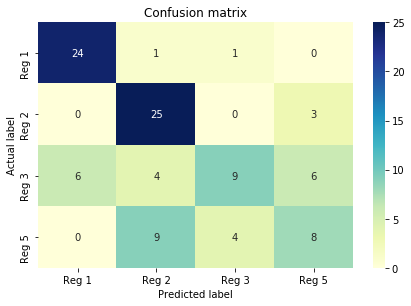

In [18]:
evaluate_performance(val_y, estimates)

In [22]:
metrics.accuracy_score(val_y, estimates)

0.66

# Cross-Validation: max_depth

In [39]:
train_accuracies = []
val_accuracies = []
for i in range(1,11):
    rf_model = sklearn.ensemble.RandomForestClassifier(n_estimators=10, max_depth=i, random_state=229)
    rf_model.fit(train_X, train_y)

    val_estimates = rf_model.predict(val_X)
    train_estimates = rf_model.predict(train_X)
    train_accuracies.append(metrics.accuracy_score(train_y, train_estimates))
    val_accuracies.append(metrics.accuracy_score(val_y, val_estimates))

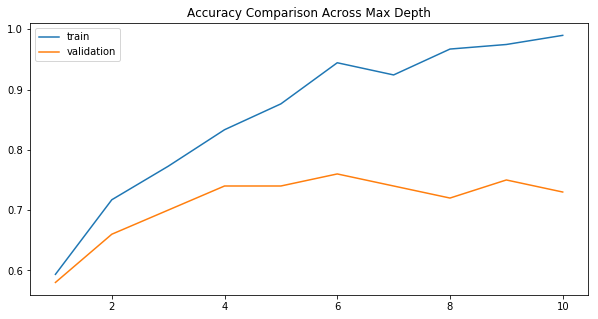

In [42]:
plt.figure(figsize=(10,5))
plt.plot(range(1,11), train_accuracies, label="train")
plt.plot(range(1,11), val_accuracies, label="validation")
plt.legend()
plt.title("Accuracy Comparison Across Max Depth")
plt.show()

# Cross Validation: n_estimators

In [52]:
train_accuracies = []
val_accuracies = []
for i in range(1,50):
    rf_model = sklearn.ensemble.RandomForestClassifier(n_estimators=i, max_depth=6, random_state=229)
    rf_model.fit(train_X, train_y)

    val_estimates = rf_model.predict(val_X)
    train_estimates = rf_model.predict(train_X)
    train_accuracies.append(metrics.accuracy_score(train_y, train_estimates))
    val_accuracies.append(metrics.accuracy_score(val_y, val_estimates))

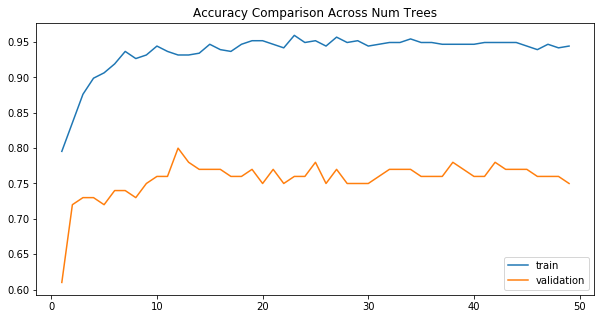

In [53]:
plt.figure(figsize=(10,5))
plt.plot(range(1,50), train_accuracies, label="train")
plt.plot(range(1,50), val_accuracies, label="validation")
plt.legend()
plt.title("Accuracy Comparison Across Num Trees")
plt.show()

In [49]:
np.argmax(val_accuracies)

11

# Train Best Model

In [50]:
rf_model = sklearn.ensemble.RandomForestClassifier(n_estimators=12, max_depth=6, random_state=229)
rf_model.fit(train_X, train_y)

estimates = rf_model.predict(val_X)

Misclassified samples: 20
Classification Report:
              precision    recall  f1-score   support

           1       0.81      1.00      0.90        26
           2       0.89      0.89      0.89        28
           3       0.71      0.68      0.69        25
           5       0.75      0.57      0.65        21

   micro avg       0.80      0.80      0.80       100
   macro avg       0.79      0.79      0.78       100
weighted avg       0.80      0.80      0.79       100



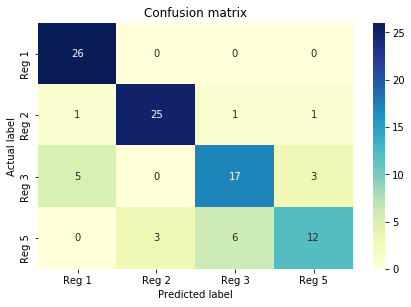

In [51]:
evaluate_performance(val_y, estimates)

# Try adding the extra features

# -------------------------------------------------------------------------------------------

## Read in Data

In [4]:
df, train, val, test = load_data.load_coral_data(complete=True, CV=False, convert_to_categorical=True)
# isolate the predictors and labels for both the training and test set
train_X, train_y, pred_names = load_data.get_features_and_response(train, with_feature_eng = True)
val_X, val_y, _ = load_data.get_features_and_response(val, with_feature_eng = True)
print(train.shape)
print(val.shape)

(396, 46)
(100, 46)


In [5]:
print("Features Used: " , pred_names.get_values())

Features Used:  ['Effluent' 'Sedimentation' 'New_Development' 'Habitat_Modification'
 'Invasive_Algae' 'Fishing_Comm_Total' 'Fishing_NonComm_Boat_Total'
 'Fishing_NonComm_Shore_Line' 'Fishing_NonComm_Shore_Net'
 'Fishing_NonComm_Shore_Spear' 'SST_CLIM_M' 'SST_STD' 'CHL_CLIM_M'
 'CHL_ANOM_F' 'PAR_CLIM_M' 'PAR_STD' 'WAV_CLIM_M' 'WAV_ANOM_F'
 'Complexity' 'Depth' 'sqrt_power_x_compexity' 'log_power_over_depth'
 'complexity_over_depth' 'Irradiance_x_inv_algae' 'both_anomolies']


In [6]:
# # isolate the predictors and labels for both the training and test set
# train_X = train.iloc[:, 14:34]
# train_y = train['Regime']

# val_X = val.iloc[:, 14:34]
# val_y = val['Regime']

# pred_names = df.iloc[:, 14:34].columns
# pred_names

## Run Model

In [7]:
rf_model = sklearn.ensemble.RandomForestClassifier(n_estimators=10, max_depth=2, random_state=229)
rf_model.fit(train_X, train_y)

estimates = rf_model.predict(val_X)

#### evaluate performance

Misclassified samples: 38
Classification Report:
              precision    recall  f1-score   support

           1       0.55      0.81      0.66        26
           2       0.75      0.75      0.75        28
           3       0.60      0.48      0.53        25
           5       0.57      0.38      0.46        21

   micro avg       0.62      0.62      0.62       100
   macro avg       0.62      0.60      0.60       100
weighted avg       0.62      0.62      0.61       100



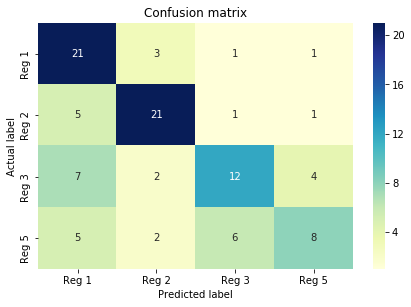

In [8]:
evaluate_performance(val_y, estimates)

In [9]:
metrics.accuracy_score(val_y, estimates)

0.62

# Cross-Validation: max_depth

In [10]:
train_accuracies = []
val_accuracies = []
for i in range(1,11):
    rf_model = sklearn.ensemble.RandomForestClassifier(n_estimators=10, max_depth=i, random_state=229)
    rf_model.fit(train_X, train_y)

    val_estimates = rf_model.predict(val_X)
    train_estimates = rf_model.predict(train_X)
    train_accuracies.append(metrics.accuracy_score(train_y, train_estimates))
    val_accuracies.append(metrics.accuracy_score(val_y, val_estimates))

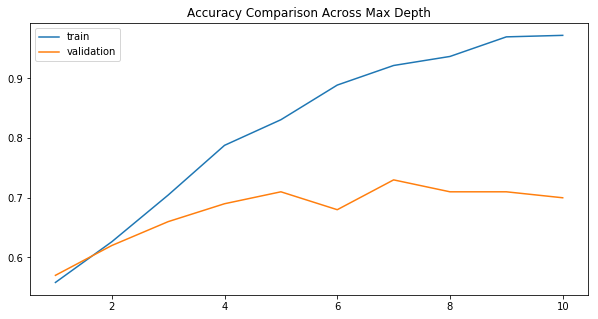

In [11]:
plt.figure(figsize=(10,5))
plt.plot(range(1,11), train_accuracies, label="train")
plt.plot(range(1,11), val_accuracies, label="validation")
plt.legend()
plt.title("Accuracy Comparison Across Max Depth")
plt.show()

# Cross Validation: n_estimators

In [12]:
train_accuracies = []
val_accuracies = []
for i in range(1,50):
    rf_model = sklearn.ensemble.RandomForestClassifier(n_estimators=i, max_depth=7, random_state=229)
    rf_model.fit(train_X, train_y)

    val_estimates = rf_model.predict(val_X)
    train_estimates = rf_model.predict(train_X)
    train_accuracies.append(metrics.accuracy_score(train_y, train_estimates))
    val_accuracies.append(metrics.accuracy_score(val_y, val_estimates))

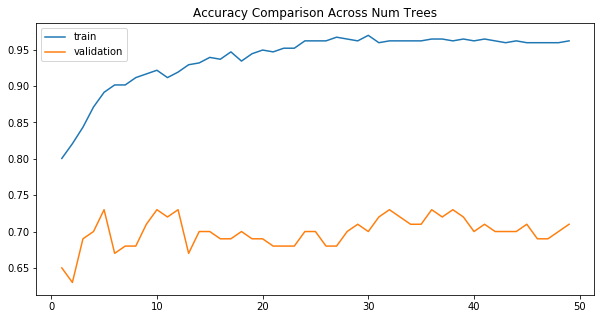

In [13]:
plt.figure(figsize=(10,5))
plt.plot(range(1,50), train_accuracies, label="train")
plt.plot(range(1,50), val_accuracies, label="validation")
plt.legend()
plt.title("Accuracy Comparison Across Num Trees")
plt.show()

In [14]:
np.argmax(val_accuracies)

4

# Train Best Model

In [15]:
rf_model = sklearn.ensemble.RandomForestClassifier(n_estimators=4, max_depth=6, random_state=229)
rf_model.fit(train_X, train_y)

estimates = rf_model.predict(val_X)

Misclassified samples: 32
Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.77      0.71        26
           2       0.76      0.68      0.72        28
           3       0.67      0.72      0.69        25
           5       0.61      0.52      0.56        21

   micro avg       0.68      0.68      0.68       100
   macro avg       0.68      0.67      0.67       100
weighted avg       0.68      0.68      0.68       100



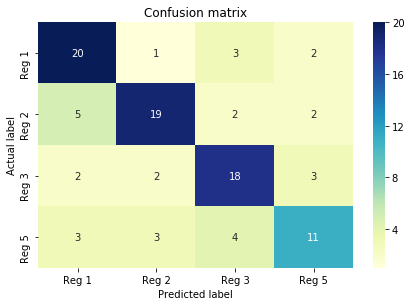

In [16]:
evaluate_performance(val_y, estimates)